# CNN

In [ ]:
# @title Imports

# General
import numpy as np
import pandas as pd
from scipy.stats import zscore
import matplotlib as mpl
from matplotlib import pyplot as plt
import random
from statistics import mean

# Deep learning
import torch
from torch import nn, optim
from torchvision import transforms

# Images
import PIL.Image as Image
import cv2
import imageio

# # Response visualizations
# !pip install umap-learn
# import umap

# Set random seeds for reproducibility
np.random.seed(12)
torch.manual_seed(12)

In [ ]:
# @title Helper Functions


def get_hidden_activity(net, stimuli, layer_labels):
  """Retrieve internal representations of network

  Args:
    net (nn.Module): deep network
    stimuli (torch.Tensor): input to the network
    layer_labels (list): list of strings with labels of each layer for which
      to return its internal representations

  Returns:
    dict: internal representations at each layer of the network, in
      numpy arrays. The keys of this dict are the strings in layer_labels.

  """

  hidden_activity = {}

  # Attach hooks to each layer of the network to store hidden
  # representations in hidden_activity
  def hook(module, input, output):
    module_label = list(net._modules.keys())[np.argwhere([module == m for m in net._modules.values()])[0, 0]]
    if module_label in layer_labels:
      hidden_activity[module_label] = output.view(stimuli.shape[0], -1).cpu().detach().numpy()
  hooks = [layer.register_forward_hook(hook) for layer in net.children()]

  # Run stimuli through the network
  pred = net.predict(stimuli)

  # Remove the hooks
  [h.remove() for h in hooks]

  return hidden_activity

def get_probabilities(difficulty=None, one_stim=False):

  # Defaults
  NoGo = .2         # Probability of NoGo
  OneStim = .2      # Probability of one stimulus: set to 1 if want all 1 stim data

  diff_0 = .2       # Probability of intensity difference = 0
  diff_25 = .2      # Probability of intensity difference = .25
  diff_50 = .1      # Probability of intensity difference = .50
  diff_75 = .1      # Probability of intensity difference = .75
  diff_1 = .2       # Probability of intensity difference = 1

  probabilities = [NoGo, OneStim, diff_0, diff_25, diff_50, diff_75, diff_1]

  return probabilities

def get_resp_layer_labels(net):
  layer_names = ['conv1', 'pool1', 'conv2', 'pool2', 'finalpool', 'fc1', 'fc2', 'out']
  # layer_names = list(net._modules.keys())
  return layer_names

def get_unique_labels(multiple=1, cast=None, alt=None, diff=False):

  if alt == 1:
    intensities = [0., .25, .50, .75, 1.]
    labels = []

    for intens1 in intensities:
      for intens2 in intensities:
        case = [intens1,0.,intens2]
        if cast=='strings': case = str([intens1,intens2])
        labels.extend([case]*multiple)

  elif alt == 2:
    intensities = [i/10 for i in range(1,10)]
    labels = []

    for intens1 in intensities:
      for intens2 in intensities:
        case = [intens1,0.,intens2]
        if cast=='strings': case = str([intens1,intens2])
        labels.extend([case]*multiple)

  elif diff:
    labels = []
    labels_by_diff = [
            [0.0, 0.0, 0.0],
            [0.0, 0.0, 0.25],
            [0.0, 0.0, 0.5],
            [0.0, 0.0, 1.0],
            [0.25, 0.0, 0.0],
            [0.5, 0.0, 0.0],
            [1.0, 0.0, 0.0],
            [1.0, 0.0, 0.25],
            [0.25, 0.0, 1.0],
            [1.0, 0.0, 0.5],
            [0.5, 0.0, 1.0],
            [0.25, 0.0, 0.5],
            [0.5, 0.0, 0.25],
            [0.25, 0.0, 0.25],
            [0.5, 0.0, 0.5],
            [1.0, 0.0, 1.0]
            ]
    for label in labels_by_diff:
      labels.extend([label]*multiple)

  else:
    intensities = [0., .25, .50, 1.]
    labels = []

    for intens1 in [0.]:
      for intens2 in intensities:
        case = [intens1,0.,intens2]
        if cast=='strings': case = str([intens1,intens2])
        labels.extend([case]*multiple)
    for intens1 in intensities[1:]:
      for intens2 in [0.]:
        case = [intens1,0.,intens2]
        if cast=='strings': case = str([intens1,intens2])
        labels.extend([case]*multiple)
    for intens1 in intensities[1:]:
      for intens2 in intensities[1:]:
        case = [intens1,0.,intens2]
        if cast=='strings': case = str([intens1,intens2])
        labels.extend([case]*multiple)

  return labels

# def resp_label_remap():

#   labels = get_unique_labels()
#   for i, label in enumerate(labels):

def get_resp_layer_inputs(labels=None, diff=False, alt=None):

  # Labels for each of the cases
  if not labels:
    labels = get_unique_labels(multiple=4,diff=diff)

  data = pd.DataFrame(columns=['stimulus', 'label'])
  for label in labels:
    image, _, _ = generate_image(label)
    norm_transform = transforms.ToTensor()
    image_norm = norm_transform(image)
    new_row = pd.DataFrame([[image_norm, label]], columns=['stimulus', 'label'])
    data = pd.concat([data, new_row], ignore_index=True)

  resp_stimuli = torch.stack([data['stimulus'][i].to(torch.float32) for i in range(len(labels))])
  resp_labels = torch.from_numpy(np.array(labels)).type(torch.float).unsqueeze(-1)
  resp_labels = torch.reshape(resp_labels,(len(labels),3))

  if torch.cuda.is_available():
    resp_stimuli = resp_stimuli.to('cuda')
    resp_labels = resp_labels.to('cuda')
  return resp_stimuli

def run_UMAP(responses, label, len_col=16):

  # # Response visualizations
  !pip install umap-learn
  import umap

  colors = []
  for i in range(len_col):
    colors.extend([i]*4)
  colors2 = [color/25 for color in colors]
  color_map = plt.cm.get_cmap('viridis')
  colors_viridis = color_map(colors2)

  images = []
  for resp in responses:
    fig, ax = plt.subplots()
    ax.set_title(f'{label} layer responses')

    resp_lowd = umap.UMAP(random_state=42, min_dist=0.4, n_neighbors=15).fit_transform(resp)
    labels = get_unique_labels(cast='strings')

    x, y = resp_lowd[:, 0], resp_lowd[:, 1]
    pts = ax.scatter(x, y, c=colors, cmap='viridis', vmin=min(colors), vmax=max(colors))
    fig.colorbar(pts, ax=ax, ticks=np.linspace(min(colors), max(colors), 4),
                  label='Stimulus')

    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.set_xticks([])
    ax.set_yticks([])
    # ax.legend(get_unique_labels(cast='strings'),bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.savefig('/content/test.png')

    plt.close()
    image_file = Image.open('/content/test.png')
    image = np.asarray(image_file)
    images.append(image)
  return images

def make_gif(embeddings, title: str):
  embedding_images = []
  for mat in embeddings:#[0::2]:
      image = Image.fromarray(mat)
      embedding_images.extend([image]*7)
  imageio.mimsave(f'/content/{title}.gif', embedding_images)

In [ ]:
colors = []
for i in range(25):
  colors.extend([i]*4)
colors2 = [color/25 for color in colors]
color_map = plt.cm.get_cmap('viridis')
color_map(colors2)
colors2[0]

<ipython-input-3-8529ed10124a>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis')


0.0

In [ ]:
# @title Generate Data

def generate_image(label, width: int=902, height: int=600, radius_interval: tuple=(40,50)) -> tuple:
  '''
    label: Array-like with length 3. Specifies intensity of image on each screen.
           Possible values: {0, .25, .5, 1}
    width: Image width in pixels
    height: Image height in pixels
    radius_interval: Range of stimulus radii to be used by random generator
  '''

  def draw_circle(image, center_x, center_y, radius, intensity):
    cv2.circle(image, (center_x, center_y), radius, intensity, -1)

    # Gabor Effect
    start_point = (center_x, center_y - radius)
    end_point = (center_x - radius, center_y)
    cv2.line(image, start_point, end_point, 255, radius*2//5)

    start_point = (center_x + radius, center_y)
    end_point = (center_x, center_y + radius)
    cv2.line(image, start_point, end_point, 255, radius*2//5)

    start_point = (center_x + int(np.sqrt(2) / 2 * radius), center_y - int(np.sqrt(2) / 2 * radius))
    end_point = (center_x - int(np.sqrt(2) / 2 * radius), center_y + int(np.sqrt(2) / 2 * radius))
    cv2.line(image, start_point, end_point, 255, radius*2//5)

    return image

  # Adjust label vector to account for intensity of 255 not working
  label_original = label.copy()
  label = [.999 if intensity == 1 else intensity for intensity in label]

  # Initialize canvas
  image = np.zeros((height, width, 1), dtype=np.uint8) + 255

  # Control param for thickness used throughout
  thickness = 1

  # Screen Split lines
  start_point1 = ((width-2) // 3, 0)
  end_point1 = ((width-2) // 3, 599)
  start_point2 = (2 * (width-2) // 3, 0)
  end_point2 = (2 * (width-2) // 3, 599)

  color = 0 # Color of center split line
  cv2.line(image, start_point1, end_point1, color, thickness)
  cv2.line(image, start_point2, end_point2, color, thickness)


  # Generate left circle
  intensity_left = 255*(1-label[0])
  if intensity_left:
    radius_left = 100 #np.random.randint(radius_interval[0], radius_interval[1])
    center_x_left = 150 #np.random.randint(radius_left, (width-2)//3 - 1 - radius_left)
    center_y_left = 300 #np.random.randint(radius_left, height - 1 - radius_left)
    image = draw_circle(image, center_x_left, center_y_left, radius_left, intensity_left)
  else: radius_left, center_x_left, center_y_left = None, None, None


  # Generate right circle
  intensity_right = 255*(1-label[2])
  if intensity_right:
    radius_right = 100 #np.random.randint(radius_interval[0], radius_interval[1])
    center_x_right = 750 #np.random.randint(2 * (width-2) // 3  + radius_right, (width-2) - radius_right)
    center_y_right = 300 #np.random.randint(radius_right, height - 1 - radius_right)
    image = draw_circle(image, center_x_right, center_y_right, radius_right, intensity_right)
  else: radius_right, center_x_right, center_y_right = None, None, None

  stim_coords = [(radius_left, center_x_left, center_y_left), (radius_right, center_x_right, center_y_right)]

  return (image, label_original, stim_coords)

def get_batch(batch_size: int, probabilities, image_gen_params: tuple=(904,600,(40,50)), preset_labels=None, preset_image=None, label_for_preset_image=None):
  '''
    size: Desired dataset size
    probabilities: Array-like of length 7. Controls probabilities of different
    conditions. Indices: [Go/NoGo, OneStim, diff=0, diff=.25, diff=.5, diff=.75, diff=1]
  '''

  width, height, radius_interval = image_gen_params

  def get_labels(batch_size: int, probabilities):

    # Possible intensity difference conditions in case of Go trial
    intensity_diffs = [0, .25, .5, .75, 1]

    # Possible combinations given an intensity difference in two stim case
    intensities_dict = {
        0 : [[ 0.25 ]*2, [ 0.5 ]*2, [ 1.0 ]*2],
      .25 : [[ 0.25, 0.5 ]],
        .5 : [[ 0.5, 1.0 ]],
      .75 : [[ 0.25, 1.0 ]]
    }

    # Generate labels
    labels = []

    for i in range(batch_size):
      # Initialize label
      label = [0]*3

      # With Bern. probability proportionate to desired chance of NoGo, end here
      if np.random.binomial(1, probabilities[0], 1):
        labels.append(label)
        continue

      # Choose Right=2 Left=0 with equal probability
      side_index = 2 if np.random.binomial(1, 0.5, 1) else 0

      # Decide on one or two stims (one stimulus is easier)
      n_stims = 1 if np.random.binomial(1, probabilities[1], 1) else 2

      # One stimulus case
      if n_stims == 1:
        # Weighted choice of intensity difference condition
        intensity_diff = random.choices(intensity_diffs, weights=probabilities[2:])[0]
        label[side_index] = intensity_diff
        labels.append(label)

      # Two stimuli case
      else:
        # Weighted choice of intensity difference condition (1 is not possible)
        intensity_diff = random.choices(intensity_diffs[:-1], weights=probabilities[2:-1])[0]

        # Choose Left and Right intensities
        values = intensities_dict[intensity_diff][random.choice(range(len(intensities_dict[intensity_diff])))]

        # Note: (side_index + 2) % 4 gives the other index, i.e. if side_index
        # is 0 (Left) this will return 2 (Right), and vice versa
        label[side_index], label[(side_index + 2) % 4] = values[0], values[1]
        labels.append(label)

    return labels

  if preset_image is None:
    if preset_labels is None:
      labels = get_labels(batch_size, probabilities)
    else: labels = preset_labels
    data = pd.DataFrame(columns=['stimulus', 'label'])#, 'coordinates'])
    for label in labels:
      image, label, coords = generate_image(label, width, height, radius_interval)
      # image_res = cv2.resize(image, dsize=(226, 150), interpolation=cv2.INTER_LINEAR)
      norm_transform = transforms.ToTensor()
      image_norm = norm_transform(image)
      new_row = pd.DataFrame([[image_norm, label]], columns=['stimulus', 'label'])#, 'coordinates'])
      data = pd.concat([data, new_row], ignore_index=True)
  else:
    norm_transform = transforms.ToTensor()
    image_norm = norm_transform(preset_image)
    labels = label_for_preset_image
    data = pd.DataFrame([[image_norm, labels]], columns=['stimulus', 'label'])
  stimuli = torch.stack([data['stimulus'][i].to(torch.float32) for i in range(batch_size)])#, device=torch.device('cuda'))
  # stimuli = torch.reshape(stimuli, (size, 226, 150))
  labels = torch.from_numpy(np.array(labels)).type(torch.float).unsqueeze(-1)
  labels = torch.reshape(labels,(batch_size,3))

  if torch.cuda.is_available():
    stimuli = stimuli.to('cuda')
    labels = labels.to('cuda')

  return stimuli, labels

In [ ]:
# from scipy.stats.distributions import truncexpon
 #@title VGG Lite

# # Based on VGG16 architecture
# class CNN(nn.Module):
#     def __init__(self, num_screens=3):
#         super(CNN, self).__init__()
#         self.layer1 = nn.Sequential(
#             nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(16),
#             nn.ReLU())
#         self.layer2 = nn.Sequential(
#             nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(16),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size = 2, stride = 2))
#         self.layer3 = nn.Sequential(
#             nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(16),
#             nn.ReLU())
#         self.layer4 = nn.Sequential(
#             nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size = 2, stride = 2))
#         self.layer5 = nn.Sequential(
#             nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(32),
#             nn.ReLU())
#         self.layer6 = nn.Sequential(
#             nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(32),
#             nn.ReLU())
#         self.layer7 = nn.Sequential(
#             nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size = 2, stride = 2))
#         self.layer8 = nn.Sequential(
#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU())
#         self.layer9 = nn.Sequential(
#             nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU())
#         self.layer10 = nn.Sequential(
#             nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size = 2, stride = 2))
#         self.layer11 = nn.Sequential(
#             nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU())
#         self.layer12 = nn.Sequential(
#             nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU())
#         self.layer13 = nn.Sequential(
#             nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size = 2, stride = 2))
#         # if self.training:
#         #   self.fc = nn.Sequential(
#         #       nn.Dropout(0.5),
#         #       nn.Linear(2240, 2240),
#         #       nn.ReLU())
#         #   self.fc1 = nn.Sequential(
#         #       nn.Dropout(0.5),
#         #       nn.Linear(2240, 1000),
#         #       nn.ReLU())
#         # else:
#         self.fc1 = nn.Sequential(
#             nn.Linear(2240, 2240, bias=False),
#             nn.ReLU())
#         self.fc2 = nn.Sequential(
#             nn.Linear(2240, 1000, bias=False),
#             nn.ReLU())
#         self.fc3 = nn.Sequential(
#             nn.Linear(1000, num_screens, bias=True))

#     def forward(self, x):
#         out = self.layer1(x)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = self.layer4(out)
#         out = self.layer5(out)
#         out = self.layer6(out)
#         out = self.layer7(out)
#         out = self.layer8(out)
#         out = self.layer9(out)
#         out = self.layer10(out)
#         out = self.layer11(out)
#         out = self.layer12(out)
#         out = self.layer13(out)
#         out = out.reshape(out.size(0), -1)
#         out = self.fc1(out)
#         out = self.fc2(out)
#         out = self.fc3(out)
#         return out

#     # Use to disable training of weights during model evaluation
#     def train(self, mode: bool = True):
#       self.training = mode
#       for module in self.children():
#           module.train(mode)
#       return self


#     def train_loop(net, probabilities, dataset_size=1000,
#           n_epochs=25, learning_rate=0.0005,
#           batch_size=100, momentum=.99, resp_viz=False):

#       # Initialize L1 loss function
#       loss_fn = nn.SmoothL1Loss()

#       # Initialize SGD optimizer with momentum
#       optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

#       # Placeholder to save loss at each iteration
#       track_loss = []

#       # Initialize response dictionary and inputs
#       if resp_viz:
#         resp_layer_labels = get_resp_layer_labels(net)
#         resp_dict = {layer : [] for layer in resp_layer_labels}
#         stimuli_for_hooks = get_resp_layer_inputs()
#       else: resp_dict = None

#       # Loop over epochs
#       for i in range(n_epochs):

#         # Loop over number of batches
#         for j in range(dataset_size//batch_size):

#           stimuli, labels = get_batch(batch_size, probabilities)

#           # Evaluate loss and update network weights
#           out = net(stimuli)  # predicted
#           loss = loss_fn(out, labels)  # evaluate loss
#           optimizer.zero_grad()  # clear gradients
#           loss.backward()  # compute gradients
#           optimizer.step()  # update weights

#           # Keep track of loss at each iteration
#           track_loss.append(loss.item())

#           # Update response dictionary
#           if resp_viz:
#             resp_model = get_hidden_activity(net, stimuli_for_hooks, resp_layer_labels)
#             for layer in resp_layer_labels:
#               resp_dict[layer].append(resp_model[layer])

#         # Track progress
#         if (i + 1) % (n_epochs // 5) == 0:
#           print(f'epoch {i + 1} | loss on last batch: {round(loss.item(),3)}')#: .3}')

#       print('training done!')

#       return track_loss, resp_dict

#     def evaluate(net, test_dataset_size, probabilities):

#       with torch.no_grad():
#         # Set model to eval mode
#         net.train(False)

#         # Initialize L1 loss function
#         loss_fn = nn.SmoothL1Loss()

#         # Placeholder to save loss for each batch
#         track_loss = []

#         # Loop over number of batches
#         for j in range(dataset_size//batch_size):

#           stimuli, labels = get_batch(batch_size, probabilities)
#           out = net(stimuli)
#           loss = loss_fn(out, labels)

#           # Keep track of loss
#           track_loss.append(loss.item())

#       return mean(track_loss)

#     def predict(net, stimuli):

#       with torch.no_grad():
#         # Set model to eval mode
#         net.train(False)
#         out = net(stimuli)

#       return out

In [ ]:
#@title TinyAlexNet

from functools import partial
from typing import Any, Optional

import torch
import torch.nn as nn
from torchsummary import summary

from torchvision.utils import _log_api_usage_once
from torchvision.transforms import Resize

__all__ = ["TinyAlexNet", "TinyAlexNet_Weights", "tinyalexnet"]


class TinyAlexNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        _log_api_usage_once(self)
        # self.resize = Resize((226, 150))
        self.conv1 = nn.Conv2d(1, 16, kernel_size=11, stride=4, padding=2)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv2 = nn.Conv2d(16, 16, kernel_size=5, padding=2)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.finalpool = nn.MaxPool2d((4,4))

        self.fc1 = nn.Linear(1872, 100) #384 #6144
        self.fc2 = nn.Linear(100, 100)
        self.out = nn.Linear(100, 3)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.finalpool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.out(x)
        return x

    # Used to disable training of weights during model evaluation
    def train(self, mode: bool = True):
      self.training = mode
      for module in self.children():
          module.train(mode)
      return self


    def train_loop(net, probabilities, dataset_size=1000,
          n_epochs=25, learning_rate=0.0005,
          batch_size=100, momentum=.99, resp_viz=False):

      # Initialize L1 loss function
      loss_fn = nn.SmoothL1Loss()

      # Initialize SGD optimizer with momentum
      optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

      # Placeholder to save loss at each iteration
      track_loss = []

      # Initialize response dictionary and inputs
      if resp_viz:
        resp_layer_labels = get_resp_layer_labels(net)
        resp_dict = {layer : [] for layer in resp_layer_labels}
        stimuli_for_hooks = get_resp_layer_inputs(alt=2)
      else: resp_dict = None

      # Loop over epochs
      for i in range(n_epochs):

        # Loop over number of batches
        for j in range(dataset_size//batch_size):

          stimuli, labels = get_batch(batch_size, probabilities)

          # Evaluate loss and update network weights
          out = net(stimuli)  # predicted
          loss = loss_fn(out, labels)  # evaluate loss
          optimizer.zero_grad()  # clear gradients
          loss.backward()  # compute gradients
          optimizer.step()  # update weights

          # Keep track of loss at each iteration
          track_loss.append(loss.item())

        # Update response dictionary
        if resp_viz:
          if (i + 1) % (n_epochs // 50) == 0:
            resp_model = get_hidden_activity(net, stimuli_for_hooks, resp_layer_labels)
            for layer in resp_layer_labels:
              resp_dict[layer].append(resp_model[layer])

        # Track progress
        if (i + 1) % (n_epochs // 5) == 0:
          print(f'epoch {i + 1} | loss on last batch: {loss.item(): 3e}')#: .3}')

      print('training done!')

      return track_loss, resp_dict

    def evaluate(net, test_dataset_size, probabilities):

      with torch.no_grad():
        # Set model to eval mode
        net.train(False)

        # Initialize L1 loss function
        loss_fn = nn.SmoothL1Loss()

        # Placeholder to save loss for each batch
        track_loss = []

        # Loop over number of batches
        for j in range(dataset_size//batch_size):

          stimuli, labels = get_batch(batch_size, probabilities)
          out = net(stimuli)
          loss = loss_fn(out, labels)

          # Keep track of loss
          track_loss.append(loss.item())

      return mean(track_loss)

    def predict(net, stimuli):

      with torch.no_grad():
        # Set model to eval mode
        net.train(False)
        out = net(stimuli)

      return out

In [ ]:
def get_probabilities(difficulty=None, one_stim=False):

  # Defaults
  NoGo = .2         # Probability of NoGo
  OneStim = 0.      # Probability of one stimulus: set to 1 if want all 1 stim data

  diff_0 = .4       # Probability of intensity difference = 0
  diff_25 = .4      # Probability of intensity difference = .25
  diff_50 = .1      # Probability of intensity difference = .50
  diff_75 = .1      # Probability of intensity difference = .75
  diff_1 = 0.       # Probability of intensity difference = 1

  probabilities = [NoGo, OneStim, diff_0, diff_25, diff_50, diff_75, diff_1]

  return probabilities

epoch 20 | loss on last batch:  2.954339e-02
epoch 40 | loss on last batch:  4.386028e-03
epoch 60 | loss on last batch:  5.720999e-04
epoch 80 | loss on last batch:  8.080217e-05
epoch 100 | loss on last batch:  2.544904e-05
training done!


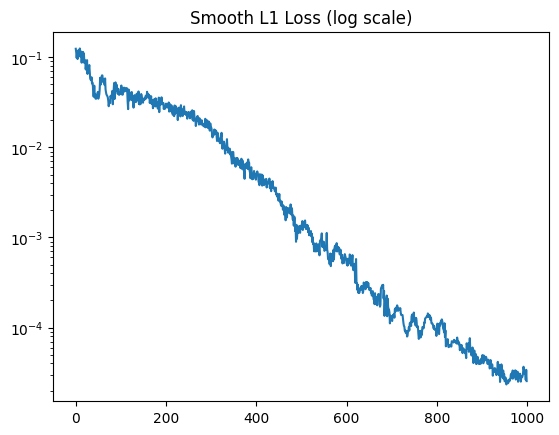

In [ ]:
#@title Train CNN

# Parameters
n_epochs = 100
batch_size = 100
dataset_size = 1000

# Original AlexNet: 50 epochs
# Small AlexNet (three conv): 200 epochs
# TinyAlexNet (two conv): 100 epochs
net = TinyAlexNet()
if torch.cuda.is_available():
    net.to('cuda')

probabilities = get_probabilities()
losses, resp_dict = TinyAlexNet.train_loop(net,
                              probabilities=probabilities,
                              dataset_size=dataset_size,
                              n_epochs=n_epochs,
                              batch_size=batch_size,
                              resp_viz=False)

plt.yscale('log')
plt.title('Smooth L1 Loss (log scale)')
plt.plot(losses)
plt.show()

# RL

In [ ]:
!pip install gymnasium
!pip install tensorflow==2.3.0
!pip install keras
!pip install keras-rl2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 8.9 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement tensorflow==2.3.0 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0)
ERROR: No matching distribution found for tensorflow==2.3.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 1.9 MB/s eta 0:00:00


In [ ]:
# Import required libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import PIL.Image as Image
import gym
import random
from gym import Env, spaces
import time
import random

# Environment Definition
class Experiment_Scope(Env):
    metadata = {"render_modes": ["rgb_array"]} # Metadata

    def __init__(self, observation_shape: tuple = (902, 600, 1), radius_interval: tuple = (50, 100), intensity_interval: tuple = (0, 5), number_of_circles: int = 1, go_cue_interval: tuple = (20, 41), CNN=None):
        """
            Initializes the Experiment_Scope object.

            Parameters:
            - observation_shape (tuple): Shape of the observation (default: (902, 600, 1))
            - radius_interval (tuple): Interval for circle radius (default: (10, 50))
            - intensity_interval (tuple): Interval for circle intensity (default: (0, 5))
            - number_of_circles (int): Number of circles (default: 1)
            - cue_interval (tuple): Interval for go cue time (default: (20, 41))
        """
        super(Experiment_Scope, self).__init__()

        self.observation_shape = observation_shape
        self.observation_space = spaces.Box(low=-105, high=105, shape=(5, ))

        self.action_space = spaces.Discrete(3)

        self._action_to_value = {
            0 : -5, # Left
            1 : 0, # No Op
            2 : +5, # Right
        }

        self.render_mode = 'rgb_array'
        self.screen = np.zeros(self.observation_shape) + 255
        self.screen_part = ""
        self.intensity_vector = None

        self.decision_var = 0
        self.is_done = False
        self.time_step = 1
        self.go_cue_time = 1 #np.random.randint(go_cue_interval[0], go_cue_interval[1])
        self.cue_played = False

        self.radius_interval = radius_interval
        self.intensity_interval = intensity_interval
        # self.number_of_circles = number_of_circles
        self.cue_interval = go_cue_interval
        self.CNN = None

    def _get_obs(self) -> dict:
        """
            Returns a dictionary containing the observation variables.

            Returns:
                dict: A dictionary containing the observation variables.
                    - 'decision_var': The value of the decision variable.
                    - 'cue_played': Whether cue played or not.
        """
        if self.CNN is not None:
          environment_image_input, _ = get_batch(batch_size=1, probabilities=probabilities, preset_image=self.screen, label_for_preset_image=self.intensity_vector)
          obs_vec = TinyAlexNet.predict(self.CNN, environment_image_input).cpu().detach().numpy().reshape(3,)
          return np.append(obs_vec, [self.decision_var, int(self.cue_played)])

        return np.array([self.intensity_vector[0]/100, self.intensity_vector[1]/100, self.intensity_vector[2]/100, self.decision_var, int(self.cue_played)])

    def _get_info(self) -> dict:
        """
            Returns a dictionary containing information about the object.

            Returns:
                dict: A dictionary with the following keys:
                    - 'is_done': A boolean indicating whether the task is done or not.
                    - 'time_step': An integer representing the time step of the task.
        """
        return {'is_done': self.is_done, "time_step": self.time_step}

    def _generate_image(self) -> tuple:
        """
            Generates an image with circles and Gabor effects on different parts of the screen.

            Returns:
                tuple: A tuple containing the generated image, the screen part where the circles are located,
                    and the intensities of each screen part.
        """
        width = self.observation_shape[0]
        height = self.observation_shape[1]
        # number_of_circles = np.random.choice([0,1,2])
        intensity_interval = self.intensity_interval
        radius_interval = self.radius_interval
        image = np.zeros((height, width, 1), dtype=np.uint8) + 255
        # parts = [1, 3] #[1, 2, 3]
        # screen_intensities = np.zeros((3, ))
        left_circles = 0
        right_circles = 0
        middle_circles = 0
        color = 0
        thickness = 1
        # for _ in range(3):
        #     intensity = np.random.choice([.0, 0.25, 0.5, .99])#np.random.randint(intensity_interval[0], intensity_interval[1])
        #     int_tmp = intensity
        #     intensity = 255*(1-intensity)#255 - (2 ** (2 * intensity) - 1)
        #     radius = 100#np.random.randint(radius_interval[0], radius_interval[1])
        #     image_part = random.choice(parts)
        #     parts.remove(image_part)
        #     if image_part == 1:
        #         # Left Screen
        #         left_circles += 1
        #         center_x = 150#np.random.randint(radius, (width-2)//3 - 1 - radius)
        #         center_y = 300#np.random.randint(radius, height - 1 - radius)
        #         screen_intensities[0] = int_tmp

        #     elif image_part == 2:
        #         # Middle Screen
        #         middle_circles += 1
        #         center_x = np.random.randint((width-2) // 3 + radius, 2 * (width-2) // 3 - 1 - radius)
        #         center_y = np.random.randint(radius, height - 1 - radius)
        #         screen_intensities[1] = intensity#int_tmp

        #     else:
        #         # Right Screen
        #         right_circles += 1
        #         center_x = 750#np.random.randint(2 * (width-2) // 3  + radius, (width-2) - radius)
        #         center_y = 300#np.random.randint(radius, height - 1 - radius)
        #         screen_intensities[2] = intensity#int_tmp

        def draw_circle(image, center_x, center_y, radius, intensity):
          cv2.circle(image, (center_x, center_y), radius, intensity, -1)

          # Gabor Effect
          start_point = (center_x, center_y - radius)
          end_point = (center_x - radius, center_y)
          cv2.line(image, start_point, end_point, 255, radius*2//5)

          start_point = (center_x + radius, center_y)
          end_point = (center_x, center_y + radius)
          cv2.line(image, start_point, end_point, 255, radius*2//5)

          start_point = (center_x + int(np.sqrt(2) / 2 * radius), center_y - int(np.sqrt(2) / 2 * radius))
          end_point = (center_x - int(np.sqrt(2) / 2 * radius), center_y + int(np.sqrt(2) / 2 * radius))
          cv2.line(image, start_point, end_point, 255, radius*2//5)

          return image

        # intensity = random.choices([.0, 0.25, 0.5, .99], k=2)
        intensity = random.sample([.0, 0.25, 0.5, .99], 2)

        # Generate left circle
        intensity_left = 255*(1-intensity[0])
        radius_left = 100#np.random.randint(radius_interval[0], radius_interval[1])
        center_x_left = 150#np.random.randint(radius_left, (width-2)//3 - 1 - radius_left)
        center_y_left = 300#np.random.randint(radius_left, height - 1 - radius_left)
        image = draw_circle(image, center_x_left, center_y_left, radius_left, intensity_left)
        left_circles += 1


        # Generate right circle
        intensity_right = 255*(1-intensity[1])
        radius_right = 100#np.random.randint(radius_interval[0], radius_interval[1])
        center_x_right = 750#np.random.randint(2 * (width-2) // 3  + radius_right, (width-2) - radius_right)
        center_y_right = 300#np.random.randint(radius_right, height - 1 - radius_right)
        image = draw_circle(image, center_x_right, center_y_right, radius_right, intensity_right)
        right_circles += 1

        screen_intensities = np.array([intensity[0], 0.0, intensity[1]])
        # cv2.circle(image, (center_x, center_y), radius, intensity, -1)
        # # Gabor Effect
        # start_point = (center_x, center_y - radius)
        # end_point = (center_x - radius, center_y)
        # cv2.line(image, start_point, end_point, 255, radius*2//5)

        # start_point = (center_x + radius, center_y)
        # end_point = (center_x, center_y + radius)
        # cv2.line(image, start_point, end_point, 255, radius*2//5)

        # start_point = (center_x + int(np.sqrt(2) / 2 * radius), center_y - int(np.sqrt(2) / 2 * radius))
        # end_point = (center_x - int(np.sqrt(2) / 2 * radius), center_y + int(np.sqrt(2) / 2 * radius))
        # cv2.line(image, start_point, end_point, 255, radius*2//5)

        # Screen Split lines
        start_point1 = ((width-2) // 3, 0)
        end_point1 = ((width-2) // 3, 599)
        start_point2 = (2 * (width-2) // 3, 0)
        end_point2 = (2 * (width-2) // 3, 599)

        cv2.line(image, start_point1, end_point1, color, thickness)
        cv2.line(image, start_point2, end_point2, color, thickness)

        screen_part = None
        if right_circles > 0 and (left_circles == 0 and middle_circles == 0):
            screen_part = "right"

        elif left_circles > 0 and (right_circles == 0 and middle_circles == 0):
            screen_part = "left"

        elif middle_circles > 0 and (right_circles == 0 and left_circles == 0):
            screen_part = "middle"

        elif right_circles > 0 and left_circles > 0 and middle_circles == 0:
            screen_part = "right-left"

        elif middle_circles > 0 and left_circles > 0 and right_circles == 0:
            screen_part = "middle-left"

        elif right_circles > 0 and middle_circles > 0 and left_circles == 0:
            screen_part = "right-middle"

        elif right_circles > 0 and left_circles > 0 and middle_circles > 0:
            screen_part = "right-middle-left"

        else:
            screen_part = ""

        # image, screen_part, screen_intensities
        return (image, screen_part, screen_intensities)

    def reset(self, seed=None, options=None):
        """
            Resets the environment to its initial state.

            Args        seed (int): Optional. The random seed used for generating random numbers.
                options (dict): Optional. Additional options for resetting the environment.

            Returns:
                    observation: The initial observation of the environment.
                    info: Additional information about the environment's state.

            Raises:
                Any exceptions that may occur during the reset process.

            Notes:
                - This method should be called before starting a new episode or when the environment needs to be reset.
                - The `seed` parameter can be used to reproduce the same sequence of random numbers for consistent results.
                - The `options` parameter can be used to pass any additional configuration options specific to the environment.

        """
        super().reset(seed=seed)

        self.screen, self.screen_part, self.intensity_vector = self._generate_image()

        self.decision_var = 0
        self.is_done = False
        self.time_step = 1
        self.go_cue_time = np.random.randint(self.cue_interval[0], self.cue_interval[1])

        observation = self._get_obs()
        info = self._get_info()

        return observation, info

    def step(self, action):
        """
            Executes a single step in the decision-making process.

            Args:
                action (int): The action to take.

            Returns:
                tuple: A tuple containing the observation, reward, and info.

            Raises:
                None

        """
        self.screen, self.screen_part, self.intensity_vector = self._generate_image()
        if self.time_step >= self.go_cue_time:
            self.cue_played = True

        if not self.cue_played:
          self.time_step += 1
          observation = self._get_obs()
          info = self._get_info()

          return observation, 0, self.is_done, None, info

        self.decision_var += (action - 1) * 5
        if self.decision_var >= 15:
            # Right Decision
            self.is_done = True
            if not self.go_cue_time:
                # Make decision before go cue sound
                reward = -300
            else:
                # Make decision after go cue sound
                # if 'right' in self.screen_part:
                if self.intensity_vector[2] > self.intensity_vector[0]:
                    reward = 200
                else:
                    reward = -100

        elif self.decision_var <= -15:
            # Left Decision
            self.is_done = True
            if not self.cue_played:
                # Make decision before go cue sound
                reward = -300
            else:
                # Make decision after go cue sound
                # if 'left' in self.screen_part:
                if self.intensity_vector[0] > self.intensity_vector[2]:
                    reward = 200
                else:
                    reward = -100

        # elif self. decision_var <= -15:
        #     # Left Decision
        #     self.is_done = True
        #     if not self.cue_played:
        #         # Make decision before go cue sound
        #         reward = -300
        #     else:
        #         # Make decision after go cue sound
        #         # if 'left' in self.screen_part:
        #         if self.intensity_vector[0] > self.intensity_vector[2]:
        #             reward = 200
        #         else:
        #             reward = -100

        elif self.time_step >= 200:
            # Middle or No Stimulus
            self.is_done = True
            # if self.screen_part == "" or "middle" in self.screen_part:
            if self.intensity_vector == [0.0, 0.0, 0.0]:
                reward = 200
            else:
                reward = -100

        else:
            reward = 0
            self.time_step += 1

        # self.screen, self.screen_part, self.intensity_vector = self._generate_image()

        observation = self._get_obs()
        info = self._get_info()
        return observation, reward, self.is_done, None, info

    def render(self):
        """
            Renders the screen.

            Returns:
                The rendered screen.
        """
        return self.screen


In [ ]:
env = Experiment_Scope()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# episodes = 20 #20 shower episodes
# for episode in range(1, episodes+1):
#     state, info = env.reset()
#     done = False
#     score = 0

#     while not done:
#         action = env.action_space.sample()
#         n_state, reward, done, info = env.step(action)
#         score+=reward
#     print('Episode:{} Score:{}'.format(episode, score))

In [ ]:
# import numpy as np
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Flatten
# # from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.optimizers.legacy import Adam
# import tensorflow as tf

In [ ]:
# env.reset()[0]

In [ ]:
states = env.observation_space.shape
actions = env.action_space.n

In [ ]:
states#, actions

(5,)

In [ ]:
# def build_model(states, actions):
#   model = Sequential()
#   # model.add(Flatten(input_shape=(1, states)))
#   model.add(Dense(24, activation='relu', input_shape=(1, 5)))
#   model.add(Dense(24, activation='relu'))
#   model.add(Dense(actions, activation='linear'))
#   model.add(tf.keras.layers.Reshape((3, )))
#   return model

In [ ]:
# model = build_model(states, actions)

In [ ]:
# model.summary()

In [ ]:
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

In [ ]:
# def build_agent(model, actions):
#   policy = BoltzmannQPolicy()
#   memory = SequentialMemory(limit=1000, window_length=1)
#   dqn = DQNAgent(model=model, memory=memory, policy = policy, nb_actions = actions, nb_steps_warmup=10, target_model_update=1e-2, enable_double_dqn=False)
#   return dqn

In [ ]:
# dqn = build_agent(model, actions)
# dqn.compile(Adam(learning_rate=1e-3), metrics=['mae'])
# dqn.fit(env, nb_steps=60000, visualize=False, verbose=1)

In [ ]:
# import tensorflow as tf
# from keras.layers import Dense, Flatten
# import gym
# from rl.agents.dqn import DQNAgent
# from rl.policy import BoltzmannQPolicy
# from rl.memory import SequentialMemory

# env = gym.make('CartPole-v0')
# states = env.observation_space.shape[0]
# actions = env.action_space.n
# episodes = 10

# def buildModel(statez, actiones):
#     model = tf.keras.Sequential()
#     model.add(Flatten(input_shape=(1, statez)))
#     model.add(Dense(24, activation='relu'))
#     model.add(Dense(24, activation='relu'))
#     model.add(Dense(actiones, activation='linear'))
#     return model

# def buildAgent(modell, actionz):
#     policy = BoltzmannQPolicy()
#     memory = SequentialMemory(limit=50000, window_length=1)
#     dqn = DQNAgent(model=modell, memory=memory, policy=policy,
#                    nb_actions=actionz, nb_steps_warmup=10,
#                    target_model_update=1e-2)
#     return dqn

# model = buildModel(states, actions)
# DQN = buildAgent(model, actions)
# DQN.compile(tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['mae'])
# DQN.fit(env, nb_steps=50000, visualize=False, verbose=1)

In [ ]:
# arr = np.array([1, 2 ,3])

In [ ]:
# arr[0]

In [ ]:
!pip install stable-baselines3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.4/178.4 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 14.8 MB/s eta 0:00:00
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 0.29.0
    Uninstalling gymnasium-0.29.0:
      Successfully uninstalled gymnasium-0.29.0


In [ ]:
!pip install shimmy

# Run RL

In [ ]:
import gymnasium as gym

from stable_baselines3 import DQN

env.CNN = net
model = DQN("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=100000, log_interval=4)
# model.save("dqn_cartpole")

# del model # remove to demonstrate saving and loading

# model = DQN.load("dqn_cartpole")
obs, info = env.reset()

total_reward = 0
while True:
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    if terminated or truncated:
        break

/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | nan      |
|    n_updates        | 236446   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.26     |
|    ep_rew_mean      | 50       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 299304   |
|    fps              | 184      |
|    time_elapsed     | 5411     |
|    total_timesteps  | 995797   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | nan      |
|    n_updates        | 236449   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.26     |
|    ep_rew_mean      | 47       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 299308   |
|   

In [ ]:
total_reward

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-100

In [ ]:
# model.action_probability(env.screen)
from stable_baselines3.deepq.policies import MlpPolicy
env2 = gym.make('CartPole-v1')

model = DQN(MlpPolicy, env2, verbose=1)
model.get_env()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ModuleNotFoundError: ignored

0
None
[0.5 0.  0. ] 

[ 1.00127983e+00 -3.11510265e-03  2.58154929e-01 -5.00000000e+00
  1.00000000e+00]
reward:  0
None
[0.99 0.   0.25] 


0
None
[0.99 0.   0.25] 

[ 2.53410637e-01 -1.56784803e-03  5.00038207e-01 -1.00000000e+01
  1.00000000e+00]
reward:  0
None
[0.25 0.   0.5 ] 


0
None
[0.25 0.   0.5 ] 

[ 4.93200988e-01 -1.42446905e-03  1.00097680e+00 -1.50000000e+01
  1.00000000e+00]
reward:  -100
None
[0.5  0.   0.99] 




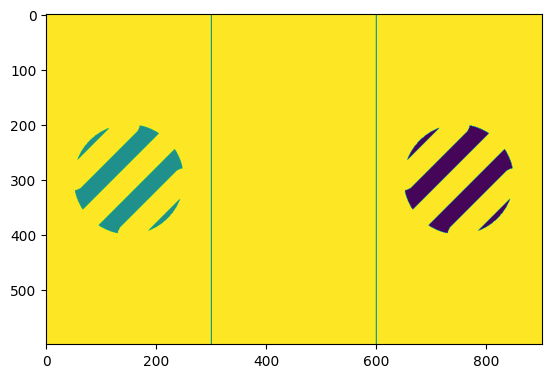

In [ ]:
obs, info = env.reset()
total_reward = 0
dec_var_over_time = []
while True:
    action, _states = model.predict(obs, deterministic=True)
    print(action)
    print(_states)
    print(env.intensity_vector, '\n')
    obs, reward, terminated, truncated, info = env.step(action)
    print(obs)
    print('reward: ', reward)
    print(truncated)
    print(env.intensity_vector, '\n\n')
    plt.imshow(env.screen)
    dec_var_over_time.append(obs[3])
    total_reward += reward
    if terminated or truncated:
        break

In [ ]:
TinyAlexNet.predict([[env.screen]])

In [ ]:
obs, info = env.reset()
total_reward = 0
dec_var_over_time = []
while True:
    action, _states = model.predict(obs, deterministic=True)
    print(action, _states)
    obs, reward, terminated, truncated, info = env.step(action)
    print(obs, reward, truncated, info, '\n', env.intensity_vector)
    plt.imshow(env.screen)
    dec_var_over_time.append(obs[3])
    total_reward += reward
    if terminated or truncated:
        break

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0 None
[ 1.99784078e-02 -4.32849675e-03  2.01885477e-02 -5.00000000e+00
  1.00000000e+00] 0 None {'is_done': False, 'time_step': 2} 
 [0. 0. 0.]
0 None
[ 1.99784078e-02 -4.32849675e-03  2.01885477e-02 -1.00000000e+01
  1.00000000e+00] 0 None {'is_done': False, 'time_step': 3} 
 [0. 0. 0.]
0 None
[ 9.99722302e-01 -8.18195194e-03  1.81921497e-02 -1.50000000e+01
  1.00000000e+00] 0 None {'is_done': False, 'time_step': 4} 
 [24.75  0.    0.  ]
0 None
[ 9.99722302e-01 -8.18195194e-03  1.81921497e-02 -2.00000000e+01
  1.00000000e+00] 0 None {'is_done': False, 'time_step': 5} 
 [24.75  0.    0.  ]
0 None
[ 1.35011785e-02 -4.03372198e-03  4.97370750e-01 -2.50000000e+01
  1.00000000e+00] 0 None {'is_done': False, 'time_step': 6} 
 [ 0.   0.  12.5]
0 None
[ 1.99784078e-02 -4.32849675e-03  2.01885477e-02 -3.00000000e+01
  1.00000000e+00] 0 None {'is_done': False, 'time_step': 7} 
 [0. 0. 0.]
0 None
[ 1.99784078e-02 -4.32849675e-03  2.01885477e-02 -3.50000000e+01
  1.00000000e+00] 0 None {'is_done

In [ ]:
from stable_baselines3 import A2C
!tensorboard --logdir ./a2c_cartpole_tensorboard/

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2023-07-27 21:59:51.163778: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.12.3 at http://localhost:6006/ (Press CTRL+C to quit)
Exception ignored in atexit callback: <function shutdown at 0x7c5a57135120>
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 2191, in shutdown
    h.release()
  File "/usr/lib/python3.10/logging/__init__.py", line 924, in release
    self.lock.release()
RuntimeError: cannot release un-acquired lock


Why is the total reward always +200 or -100?? I think 'total_reward' may be the last reward only... How do we access ep_rew_mean from the rollout?

In [ ]:
total_reward

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-100

In [ ]:
env.intensity_vector

array([ 0.  ,  0.  , 24.75])

In [ ]:
env.step(0)

(array([ 1.99784078e-02, -4.32849675e-03,  2.01885477e-02, -1.00000000e+02,
         1.00000000e+00]),
 -100,
 True,
 None,
 {'is_done': True, 'time_step': 21})

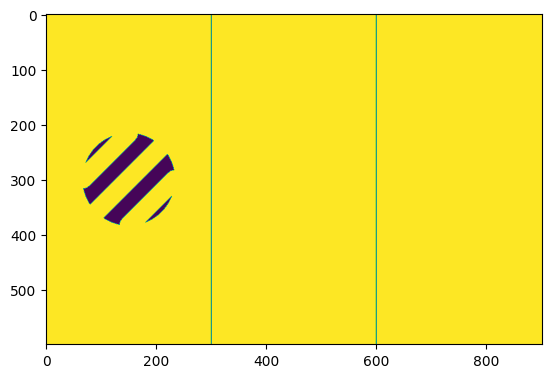

In [ ]:
img, _, _ = env._generate_image()
plt.imshow(img)

In [ ]:
dec_var_over_time

[-5.0,
 -10.0,
 -15.0,
 -20.0,
 -25.0,
 -30.0,
 -35.0,
 -40.0,
 -45.0,
 -50.0,
 -55.0,
 -60.0,
 -65.0,
 -70.0,
 -75.0,
 -80.0,
 -85.0,
 -90.0,
 -95.0,
 -100.0]

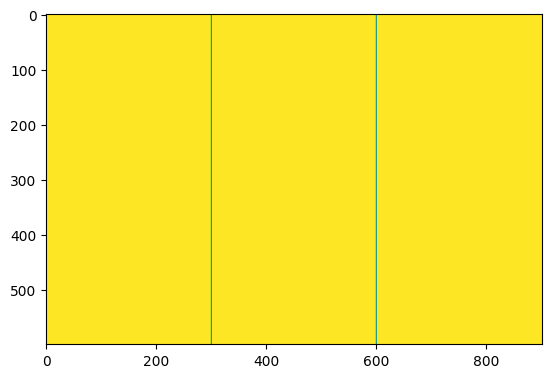

In [ ]:
# env.step(0)
plt.imshow(env.screen)

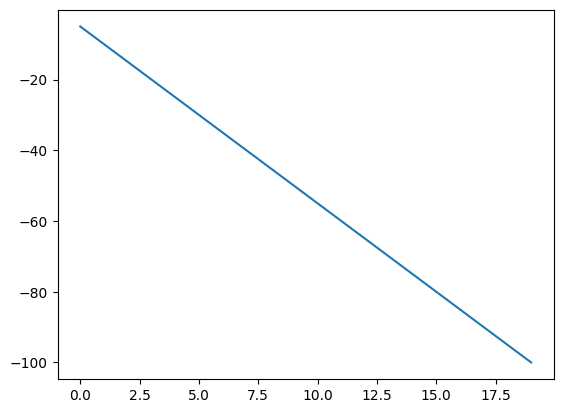

In [ ]:
import matplotlib.pyplot as plt
plt.plot(dec_var_over_time)

In [ ]:
#@title Visualizing RL weights

for name, module in model.named_modules():
    print(name)

AttributeError: ignored

In [ ]:
for layer in model.layers:
    print(layer.name)

AttributeError: ignored

In [ ]:
for parameter in model.params():
    print(parameter)

AttributeError: ignored

In [ ]:
type(model)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


stable_baselines3.dqn.dqn.DQN

No idea how to get these layers. Here's the source if anyone wants to try (see build_train() for how it's setting up the weights, I think that's the place to start): https://github.com/hill-a/stable-baselines/blob/master/stable_baselines/deepq/build_graph.py

In [ ]:
## Random scrap
# Generate a random input image (batch size of 1)
# environment_image_input, _ = get_batch(preset_labels=[dummy_obs[:-2]], batch_size=1, probabilities=probabilities)

# Get predicted intensities
# obs = net.predict(environment_image_input).cpu().detach().numpy()
# obs = np.append(obs, dummy_obs[-2:])